### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [ ]:
#!pip install -r requirements.txt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm.autonotebook import tqdm

In [ ]:
%pip install --upgrade transformers datasets accelerate deepspeed 
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets

In [ ]:
from torch.optim import AdamW
from IPython.display import clear_output
from transformers import get_scheduler

### Load data and model

In [ ]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

  0%|          | 0/3 [00:00<?, ?it/s]



Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Functions

In [ ]:
MAX_LENGTH = 128
def tokenize(qqp, tokenizer):
    def preprocess_function(examples):
        result = tokenizer(
            examples['text1'], examples['text2'],
            padding='max_length', max_length=MAX_LENGTH, truncation=True
        )
        result['label'] = examples['label']
        return result

    qqp_preprocessed = qqp.map(preprocess_function, batched=True)
    return qqp_preprocessed

In [ ]:
def calculate_accuracy(model, val_loader, device=device, timing=False):
    sigm = nn.Sigmoid()
    correct_labels, all_labels = 0, 0
    iterate = enumerate(tqdm(val_loader)) if timing else enumerate(val_loader)
    for _, batch in iterate:
        with torch.no_grad():
            predicted = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                token_type_ids=batch['token_type_ids'].to(device)
            )
            probas = sigm(predicted.logits)
            predicted_labels = torch.argmax(probas, dim=-1)
            mask = predicted_labels == batch['labels'].to(device)
            correct_labels += torch.sum(mask)
            all_labels += len(batch['labels'])

    accuracy = correct_labels / all_labels
    return accuracy


In [ ]:
def train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=5):
    metrics = {'val_accuracy': [] }
    sigm = nn.Sigmoid()
    for epoch in range(num_epochs):
        model.train()
        for idx, batch in enumerate(tqdm(train_loader)):
            output = model(
                    input_ids=batch['input_ids'].to(device),
                    attention_mask=batch['attention_mask'].to(device),
                    token_type_ids=batch['token_type_ids'].to(device),
                    labels=batch['labels'].to(device))
            loss = output.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if idx % 2500 == 0:
                acc = float(calculate_accuracy(model, val_loader))
                metrics['val_accuracy'].append((idx, acc))
                clear_output(True)
                plt.figure(figsize=(6,4))
                for i, (name, history) in enumerate(sorted(metrics.items())):
                    plt.subplot(1, len(metrics), i + 1)
                    plt.title(name)
                    plt.plot(*zip(*history))
                    plt.grid()
                plt.show()
        model.eval()
        print(f'epoch {epoch} -', calculate_accuracy(model, val_loader))

### evaluation

In [ ]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
model.to(device)
qqp_preprocessed = tokenize(qqp, tokenizer)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

In [ ]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, 
    batch_size=32, 
    shuffle=False, 
    collate_fn=transformers.default_data_collator, 
    num_workers=2
)
accuracy = calculate_accuracy(model, val_loader, timing=True)

  0%|          | 0/1264 [00:00<?, ?it/s]

In [ ]:
print(accuracy)
assert 0.9 < accuracy < 0.91

tensor(0.9084, device='cuda:0')


### train the model

(https://huggingface.co/microsoft/deberta-v3-base)

In [ ]:
model_name = "microsoft/deberta-v3-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
model.to(device)
qqp_preprocessed = tokenize(qqp, tokenizer)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

In [ ]:
val_loader = torch.utils.data.DataLoader(
    qqp_preprocessed['validation'], 
    batch_size=32, 
    shuffle=False, 
    collate_fn=transformers.default_data_collator, 
    num_workers=2
)
train_loader = torch.utils.data.DataLoader(
    qqp_preprocessed['train'], 
    batch_size=32, 
    shuffle=True, 
    collate_fn=transformers.default_data_collator, 
    num_workers=2
)
model.to(device)
num_epochs = 1 
num_training_steps = num_epochs * len(train_loader)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler(
    name = 'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps)

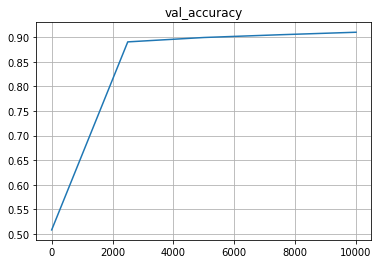

100%|██████████| 11371/11371 [3:01:41<00:00,  1.04it/s]


epoch 0 - tensor(0.9132, device='cuda:0')


In [ ]:
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)

Saving pretrained model

In [ ]:
model.save_pretrained("/content/drive/MyDrive/deberta1")

In [ ]:
def prepare_data(question, train, text=1):
  data = []
  for idx, pair in enumerate(tqdm(train)):
        with torch.no_grad():
            a = tokenizer(question, pair[f'text{text}'], padding='max_length', max_length=MAX_LENGTH, truncation=True)
            a['text'] = pair[f'text{text}']
            a['idx'] = pair['idx']
            data.append(a) 
  return data

def find_k_questions(model, data, tokenizer, k=5):
    all_probas = torch.Tensor([]).to(device)
    sigm = nn.Sigmoid()
    loader = torch.utils.data.DataLoader(
          data,
          batch_size=32, 
          shuffle=False, 
          collate_fn=transformers.default_data_collator, 
          num_workers=2
          )
    for idx, x in enumerate(tqdm(loader)):
        with torch.no_grad():
            predicted = model(
                    input_ids=x['input_ids'].to(device),
                    attention_mask=x['attention_mask'].to(device),
                    token_type_ids=x['token_type_ids'].to(device))
            probas = sigm(predicted.logits)
            probas_idx = torch.cat((x['idx'].to(device).view(1,-1), probas[:,1].view(1,-1))).permute(1,0)
            all_probas = torch.cat((all_probas, probas_idx), dim=0)
            if idx % 100 == 0:
                all_probas = all_probas[all_probas[:,-1].argsort(descending=True)][:k]
    all_probas = {data[int(k.item())]['text'] : v.item() for k, v in sorted(all_probas, key=lambda item: item[1].item(), reverse=True)}
    return list(all_probas.items())[:k]
